# Visualising your data
Now that you've run the model, lets visualise the output!

In [1]:
# an easy way to get this path is to right click on the file in the file browser and select "copy path"
output_file = "output/wb-791000/outputs/troute/troute_output_201001010000.nc"
nexus_of_interest = 791000
# the output file is a netcdf, it's an efficient way to store multi-dimensional data
# we can have many variables for many catchments for many time steps all in one file

import xarray as xr

# open the file

ds = xr.open_dataset(output_file)
ds

<xarray.Dataset> Size: 15MB
Dimensions:     (time: 1416, feature_id: 675)
Coordinates:
  * time        (time) timedelta64[ns] 11kB 01:00:00 ... 59 days 00:00:00
  * feature_id  (feature_id) int64 5kB 790961 790962 790963 ... 802125 802126
Data variables:
    flow        (feature_id, time) float32 4MB ...
    velocity    (feature_id, time) float32 4MB ...
    depth       (feature_id, time) float32 4MB ...
    nudge       (feature_id, time) float32 4MB ...
Attributes:
    TITLE:                OUTPUT FROM T-ROUTE
    file_reference_time:  2010-01-01_00:00:00
    code_version:

In [2]:
# There are no numbers in the file because xarray is lazy and doesn't load the data until you ask for it
# This is good because it means you can work with very large files without running out of memory

# Let's look at the data
ds.flow

<xarray.DataArray 'flow' (feature_id: 675, time: 1416)> Size: 4MB
[955800 values with dtype=float32]
Coordinates:
  * time        (time) timedelta64[ns] 11kB 01:00:00 ... 59 days 00:00:00
  * feature_id  (feature_id) int64 5kB 790961 790962 790963 ... 802125 802126
Attributes:
    long_name:  Flow
    units:      m3 s-1

In [3]:
# The "time" is a timedelta64 in nanoseconds, we can convert that to a datetime to make it more readable
# convert the time deltas to a datetime
import pandas as pd
def convert_to_datetime(ds):
    start_datetime = pd.to_datetime(ds.file_reference_time, format="%Y-%m-%d_%H:%M:%S")
    ds['time'] = start_datetime + pd.to_timedelta(ds.time, unit='ns')
    return ds
convert_to_datetime(ds)

<xarray.Dataset> Size: 15MB
Dimensions:     (time: 1416, feature_id: 675)
Coordinates:
  * time        (time) datetime64[ns] 11kB 2010-01-01T01:00:00 ... 2010-03-01
  * feature_id  (feature_id) int64 5kB 790961 790962 790963 ... 802125 802126
Data variables:
    flow        (feature_id, time) float32 4MB ...
    velocity    (feature_id, time) float32 4MB ...
    depth       (feature_id, time) float32 4MB ...
    nudge       (feature_id, time) float32 4MB ...
Attributes:
    TITLE:                OUTPUT FROM T-ROUTE
    file_reference_time:  2010-01-01_00:00:00
    code_version:

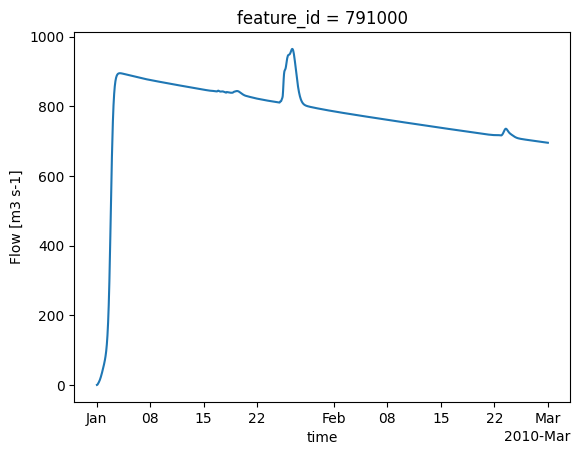

In [4]:
# we can plot the data with xarray's plotting functions
# feature_id 790961 is the catchment we are interested in
ds.sel(feature_id=nexus_of_interest).flow.plot()

# Gague Data
If you'd like to compare your results to gague data, you can use the hydrotools package!  
[https://github.com/NOAA-OWP/hydrotools/tree/main/python/nwis_client]()

In [5]:
# If you're not sure what gagues are in your data, you can check the hydrofabric
import sqlite3
# we can also plot some gaguages
def get_available_gagues(ds):
    # we can check for gagues in the hydrolocations table in the hydrofabric
    feature_ids = ds.feature_id.values
    # convert the ids to strings and prepend nex- to them
    feature_ids = ["'nex-{}'".format(id) for id in feature_ids]

    conn = sqlite3.connect("data_sources/conus.gpkg")
    c = conn.cursor()
    query = "SELECT hl_uri, id FROM hydrolocations WHERE id IN ({}) AND hl_reference == 'Gages'".format(",".join(map(str, feature_ids)))
    print(query)
    c.execute(query)
    return c.fetchall()
gagues = get_available_gagues(ds)
gagues


SELECT hl_uri, id FROM hydrolocations WHERE id IN ('nex-790961','nex-790962','nex-790963','nex-790964','nex-790965','nex-790966','nex-790967','nex-790968','nex-790969','nex-790970','nex-790971','nex-790972','nex-790973','nex-790974','nex-790975','nex-790976','nex-790977','nex-790978','nex-790979','nex-790980','nex-790981','nex-790982','nex-790983','nex-790984','nex-790985','nex-790986','nex-790987','nex-790988','nex-790989','nex-790990','nex-790991','nex-790992','nex-790993','nex-790994','nex-790995','nex-790996','nex-790997','nex-790998','nex-790999','nex-791000','nex-801492','nex-801493','nex-801494','nex-801495','nex-801496','nex-801497','nex-801498','nex-801499','nex-801500','nex-801501','nex-801502','nex-801503','nex-801504','nex-801505','nex-801506','nex-801507','nex-801508','nex-801509','nex-801510','nex-801511','nex-801512','nex-801513','nex-801514','nex-801515','nex-801516','nex-801517','nex-801518','nex-801519','nex-801520','nex-801521','nex-801522','nex-801523','nex-801524',

[('Gages-03007800', 'nex-790973'),
 ('Gages-03010500', 'nex-790976'),
 ('Gages-03010820', 'nex-790982'),
 ('Gages-03011020', 'nex-790990'),
 ('Gages-03009680', 'nex-801976')]

In [6]:
# if our original nexus of interest has a gauge, we can plot it
# if not we can plot the first gauge in the list
site_to_plot = gagues[0]
for gauge in gagues:
    nexus_id = int(gauge[1].split("-")[1])
    if nexus_id == nexus_of_interest:
        site_to_plot = gauge
        break

In [7]:
site_to_plot

('Gages-03007800', 'nex-790973')

In [8]:
site = site_to_plot[0].split("-")[1] # get the site id
matching_nexus = site_to_plot[1].split('-')[1] # get the matching nexus
print(f"Using site {site} for catchment {matching_nexus}")


# Import the NWIS IV Client
from hydrotools.nwis_client.iv import IVDataService

# Retrieve data from a single site
service = IVDataService(
    value_time_label="value_time"
)

# dates are in the format YYYY-MM-DD
# we can get them from our xarray dataset
import numpy as np
import pandas as pd

# check if the time is already a datetime
if type (ds['time'].values[0]) != np.datetime64:
   ds = convert_to_datetime(ds)
start_datetime = pd.to_datetime(ds['time'].values[0]).strftime("%Y-%m-%d")
end_datetime = pd.to_datetime(ds['time'].values[-1]).strftime("%Y-%m-%d")

observations_data = service.get(
    sites=site,
    startDT=start_datetime,
    endDT=end_datetime,
    )

# Look at the data
print(observations_data.head())

Using site 03007800 for catchment 790973
           value_time variable_name usgs_site_code measurement_unit  value  \
0 2010-01-01 01:00:00    streamflow       03007800            ft3/s  564.0   
1 2010-01-01 02:00:00    streamflow       03007800            ft3/s  564.0   
2 2010-01-01 03:00:00    streamflow       03007800            ft3/s  561.0   
3 2010-01-01 04:00:00    streamflow       03007800            ft3/s  561.0   
4 2010-01-01 05:00:00    streamflow       03007800            ft3/s  558.0   

  qualifiers series  
0      ['A']      0  
1      ['A']      0  
2      ['A']      0  
3      ['A']      0  
4      ['A']      0  


## To plot the data, we need to do some conversions
gague data is in cubic foot per second and t-route output here is in cubic meters per second.

If you're not sure what the units of the output are, you can check the netcdf files.

In [9]:
print("Ngen data is in the following units:")
print(f"Flow is in {ds.flow.units}")
print(f"Velocity is in {ds.velocity.units}")
print(f"Depth is in {ds.depth.units}")

Ngen data is in the following units:
Flow is in m3 s-1
Velocity is in m/s
Depth is in m


In [10]:
# convert the observations data to the same units as the model
observations_data['flow_cms'] = observations_data['value'] * 0.0283168

<Axes: title={'center': 'feature_id = 790973'}, xlabel='value_time', ylabel='Flow [m3 s-1]'>

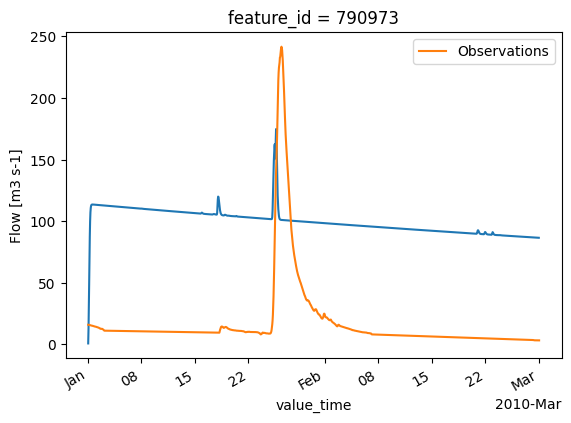

In [11]:
# plot the gague against the model output
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ds.sel(feature_id=int(matching_nexus)).flow.plot(ax=ax, label='Model')
observations_data.plot(x='value_time', y='flow_cms', ax=ax, label='Observations')
